# Introdução
O Bureau of Transportation Statistics do Departamento de Transportes dos EUA (DOT) rastreia o desempenho pontual de voos operados por grandes transportadoras aéreas. Informações resumidas sobre o número de voos como: atrasos, cancelamentos e desvios são publicados no relatório mensal do consumidor de viagens aéreas do DOT. Nessa breve análise iremos verificar o comportamento do atraso dos voos, assim respondendo algumas perguntas como:

* Será que existem mais atrasos nos fins de semana?
* Existe algum mês com mais voos?
* Existe horários com mais atrasos?
* Existe alguma CIA área com mais voos, e por consequência mais atrasos também?
* Existe alguma influência na distância do voo no atraso?

O banco de dados aqui utilizado é uma modificação da seguinte base que está disponível no [kaggle](https://www.kaggle.com/datasets/usdot/flight-delays), onde no novo banco foram removidas as observações que não possuíam informações sobre o tempo de atraso.
As variáveis utilizadas tais quais os nomes não são auto descritivos são descritas a seguir:


* **SCHEDULED_ARRIVAL**: Tempo previsto para a chegada
* **ARRIVAL_TIME**
* **ARRIVAL_DELAY**: Tempo de atraso (SCHEDULED_ARRIVAL - ARRIVAL_TIME)
* **DISTANCE**: Distância do voo


Como dito anteriormente temos foco aqui em estudar o comportamento do atraso dos voos, assim a análise será feita com concentração em variáveis que só podem ser observadas antes de saber se o voo de fato atrasou.


In [14]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from utils.utils import grouped_delay, total_bar, create_proportion



In [15]:
df = pd.read_csv("data/new_flight.csv")

df.drop(["YEAR", "FLIGHT_NUMBER", "TAIL_NUMBER", "TAXI_OUT",
"CANCELLED", "CANCELLATION_REASON"], axis=1);

/tmp/ipykernel_6536/435648177.py:1: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/new_flight.csv")


# Análise Descritiva Básica
É de fundamental importância saber a proporção de voos que atrasam, e isso é informado pela seguinte figura, assim notamos portanto que mais da metade dos voos não atrasa.

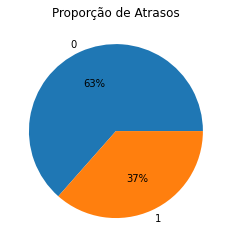

In [16]:
teste = df.groupby(["ATRASO"], as_index=False).size()

#%%
plt.pie(teste['size'], labels=teste['ATRASO'], autopct='%.0f%%')
plt.title("Proporção de Atrasos");

Em posse dessa informação, a partir de agora vamos analisar algumas variáveis e suas relações com os atrasos.

## Variáveis que podem levar o atraso
Uma maneira interessante de encontrarmos variáveis que podem levar a um possível atraso, é ver se existe alguma diferença na quantidade / proporção de atrasos em níveis dessa variáveis, e é isso que veremos nessa subseção.


## Tempo
O seguinte gráfico nos fornece um vislumbre sobre o comportamento dos voos nos dias da semana, assim nota-se uma menor quantidade de voo nos fins de semana (1 indica segunda-feira), portanto uma pergunta a se fazer é: Se esses comportamentos se mantém em relação a atrasos ou não.

### Dias da semana

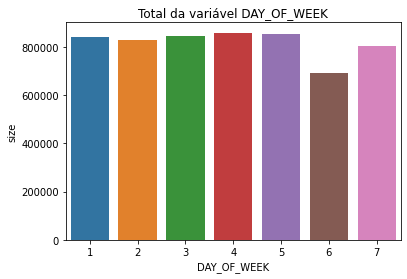

In [17]:
total_bar(df, "DAY_OF_WEEK")

Assim, pela seguinte figura percebemos que nos fins de semana acontecem menos atrasos,
ou seja, mantém-se o comportamento de menos voos, menos atrasos. Porém deve-se ressaltar que em termos de proporção tem-que dia 4 e 5 (quinta e sexta feira respectivamente) possuem mais atrasos, em outras palavras um comportamento diferente do total de voos, porém é uma proporção relativamente baixa. 
Assim pode ser interessante utilizar uma variável binária que indica se é fim de semana ou não.

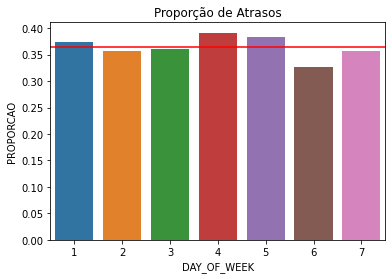

In [18]:
grouped_delay(df, "DAY_OF_WEEK") 


###  Mês
Seguindo a mesma análise vejamos a quantidade de voos por mês, nota-se que a quantidade de voos tem uma queda no mês de fevereiro. Entretanto esse comportamento não é o que acontece para a proporção de atrasos


In [19]:

data = df.groupby("MONTH", as_index=False).size()
px.area(data, x="MONTH", y="size", title='Voos por mes')


Pelo seguinte gráfico podemos ver que fevereiro é o mes que mais possui atrasos, um comportamento demasiado não esperado, pois é o que menos possui em quantidade de voos. Nota-se também uma queda de atrasos nos meses que antecedem dezembro.


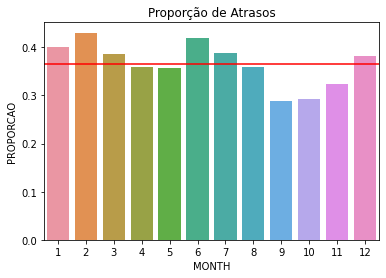

In [20]:
grouped_delay(df, "MONTH")

### Dias do mês
Notamos pelo seguinte gráfico que o único dia tal qual tem-se destaque em menos viagens é do dia 31 (nem todos meses tem dia 31!)

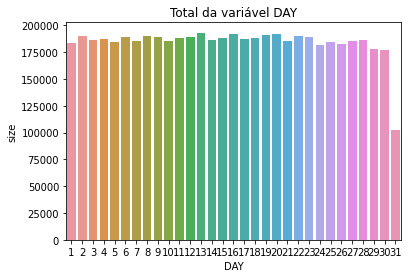

In [21]:
total_bar(df, "DAY")

Entretanto para os atrasos a quantidade tende a ter maior variação ao longo dos dias, tendo picos em dias iniciais do mês e dias próximo ao dia 15.

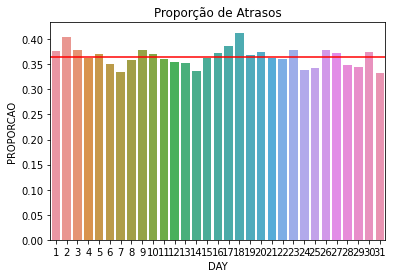

In [22]:
grouped_delay(df, "DAY")

## AIRLINE

Nota-se pela seguinte figura uma discrepância em quantidade de voos entre as companhias aéreas, sendo a WN (Southwest Airlines Co) tendo a maior quantidade, seguida de DL (Delta Air Lines Inc) e AA (American Airlines Inc.) Portanto será que maios voos implica em mais atrasos??

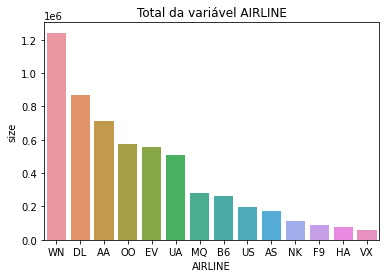

In [23]:
total_bar(df, "AIRLINE")

Aqui temos um comportamento diferente do o que foi visto até agora, pois em geral as companhias em que tem-se menos voos, são justamente as que tiveram mais atrasos (em termos de proporção). 


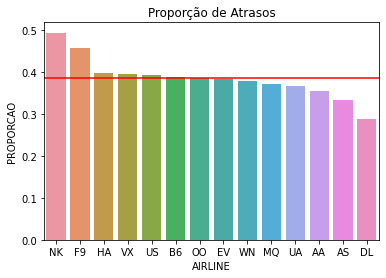

In [24]:
grouped_delay(df, "AIRLINE") 

## Distância do voo

Temos uma variável que informa em milhas a distância do voo, a distribuição da distância pode ser vista pela seguinte figura


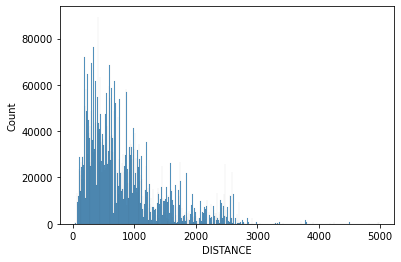

In [25]:
sns.histplot(data=df, x="DISTANCE");

Nota-se um comportamento esperado, não existem tanto voos com distâncias imensas, ou seja tem se uma assimetria, onde a maior parte dos voos está concentrada em distâncias "menores".







## DEPARTURE_DELAY

A variável DEPARTURE_DELAY como sabemos informa o tempo de delay, porem ela pode assumir valores negativos, indicando que o voo saiu antes do previsto, pela seguinte figura, temos um comportamento geral do tempo de "atraso".


<AxesSubplot:ylabel='DEPARTURE_DELAY'>

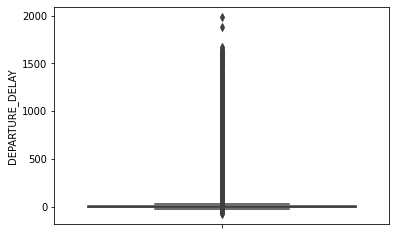

In [26]:
sns.boxplot(data=df, y="DEPARTURE_DELAY")

Nota-se portanto inúmeros valores classificados como outliers, e sendo todos eles positivos, indicando voos que atrasaram, assim também é interessante ver algumas informações desses voos. Vamos filtrar para voos que tem tempo de atraso maior (estritamente) que 1058.


In [27]:
delay_filter = df[df["DEPARTURE_DELAY"] >  1658]

Nota-se que dos 6 voos, 4 deles são da AA, e todos eles aconteceram no domingo. 

## TEMPO DE VOO
Vamos aqui analisar o tempo (em horas) previsto para a chegada do voo.

In [28]:
df['SCHEDULED_ARRIVAL'] = pd.to_datetime(df['SCHEDULED_ARRIVAL'].astype(str).str.zfill(4), format='%H%M', errors = 'coerce').dt.strftime('%H')

Pela seguinte figura, nota-se uma maior quantidade de voo concentrada as 16h e uma menor da 1 da manhã até as 4.


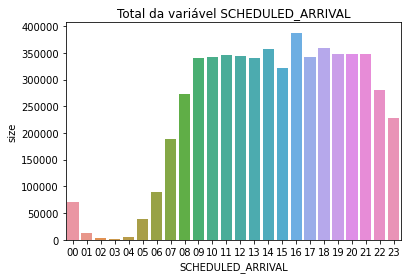

In [29]:
total_bar(df, 'SCHEDULED_ARRIVAL', order=False)

A seguinte figura informa a quantidade de atrasos por hora, notamos uma leve diferença se comparado com o total de voos, pois agora a uma "disputa" pelo primeiro lugar no horários situados entre 18 e 21h.

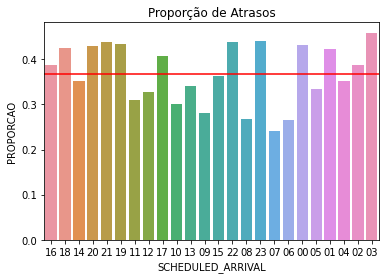

In [30]:
grouped_delay(df, "SCHEDULED_ARRIVAL", order=False, metric='median')

## Preparação da base para próxima seção

Vamos aqui criar algumas variáveis que tornem o modelo mais palatável, assim para a variável dia da semana, vamos torna-lá binária, indicando se é fim de semana ou não.


In [31]:
df["END_WEEK"] = np.where(df["DAY_OF_WEEK"] >= 6, 1, 0)

A hora prevista de chegada será deixada somente a hora, ou seja será removido os minutos.


Será também criada uma variável baseada no histórico de proporções de atraso dos aeroportos de saída. e também no histórico de atraso da CIA.

Para o aeroporto de origem, a classificação vai ser realizada em:

* Proporção de atrasos menor que 15% = OK
* Proporção de atrasos entre 15% e 30% = razoavel
* Do contrário é classificado como preocupante.


In [32]:
origin_airport = create_proportion(df, "ORIGIN_AIRPORT")
prop = origin_airport["PROPORCAO_ATRASO"]
origin_airport["HISTORICO_ATRASO"] = np.where(
    prop < 0.15, "OK", np.where((0.15 < prop) & (prop < 0.3), "razoavel", "preocupante")
)

Para o casos de CIA, a classificação vai ser dada por ter a proporção de atraso acima ou abaixo da média


In [33]:
cia_atrasos = create_proportion(df, "AIRLINE")

cia_atrasos['HISTORICO_CIA'] = np.where(cia_atrasos['PROPORCAO_ATRASO'] > cia_atrasos['PROPORCAO_ATRASO'].mean(), "preocupante", "ok")

In [34]:
df['HISTORICO_CIA'] = cia_atrasos['HISTORICO_CIA']
df['HISTORICO_ATRASO'] = origin_airport["HISTORICO_ATRASO"]

In [35]:
df_model = df[['END_WEEK', 'DISTANCE', 'SCHEDULED_ARRIVAL',
'DEPARTURE_DELAY', 'MONTH', 'HISTORICO_ATRASO', 'HISTORICO_CIA','ATRASO']]
df_model["SCHEDULED_ARRIVAL"] = df["SCHEDULED_ARRIVAL"].apply(pd.to_numeric)

/tmp/ipykernel_6536/1059777887.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Sabemos também que algumas modelos não tratam corretamente com dados faltantes (`NA` / `null`), assim é necessário verificar para as variáveis selecionadas se existe alguma observação faltante.

In [36]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5714008 entries, 0 to 5714007
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   END_WEEK           int64  
 1   DISTANCE           int64  
 2   SCHEDULED_ARRIVAL  float64
 3   DEPARTURE_DELAY    float64
 4   MONTH              int64  
 5   HISTORICO_ATRASO   object 
 6   HISTORICO_CIA      object 
 7   ATRASO             int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 348.8+ MB


Assim fica claro que a base esta "preparada" para a modelagem.

# Modelagem

Vamos nessa seção construir um modelo para predizer se o voo vai atrasar ou não, vamos a principio utilizar como variáveis preditoras (covariáveis):
* Mês do ano (numérica)
* Se é fim de semana (binária);
* Distância do voo (numérica)
* Total de atraso na saída (numérica)
* Hora prevista de chegada (numérica)
* Histórico de atraso do aeroporto de saída (categorias)
* Histórico da CIA (binária)

A base será dividida em 85% para dados de treino, e o restante para teste. Os modelos utilizados serão: Random Forest e Regressão logística.

## Random Forest


In [37]:
clf = RandomForestClassifier(n_estimators=100)

In [38]:
X = df_model.loc[:, df_model.columns != "ATRASO"]  # Features
y = df_model["ATRASO"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [39]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

ValueError: could not convert string to float: 'razoavel'

## Regressão logística





# Conclusão